In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
import numpy as np
import math
from core.synapse import DoubleExponentialSynapse, Synapse
from core.population import Population, SecondOrderPopulation
from core.utility import nmrse

Find Optimal Parameters for DoubleExponentialSynapse to Represent Jansen-Rit Alpha Kernel
------------------------------------------------------------------------------------------------------

**1. Set parameters for synapses** 

In [14]:
######################
# synapse parameters #
######################

# general synapse parameters
bin_size = 1e-4

# alpha kernel parameters
synapse_params2 = {'efficacy': -22 * 1e-3,
                   'tau': 0.02,
                   'epsilon': 5e-15}

# double-exponential synapse parameters
synapse_params1_tmp = {'tau_rise': 0.0004,
                       'tau_decay': 0.02,
                       'efficacy': 1.273 * (-1e-12),
                       'epsilon': 5e-15}

tau_rise = np.arange(0.0001, 0.0009, 0.0001)
tau_decay = np.arange(0.01, 0.09, 0.01)
efficacy = np.arange(0.5, 1.5, 0.1) * 1.273 * (-1e-12)

synapse_params1 = list()
for tr in tau_rise:
    for td in tau_decay:
        for e in efficacy:
            synapse_params1_tmp2 = synapse_params1_tmp.copy()
            synapse_params1_tmp2['tau_rise'] = tr
            synapse_params1_tmp2['tau_decay'] = td
            synapse_params1_tmp2['efficacy'] = e
            synapse_params1.append(synapse_params1_tmp2)

n_conditions = len(synapse_params1)
print('Number of total conditions: ', n_conditions)

Number of total conditions:  640


**2. Create Populations with single synapse each and look at their behavior for gaussian input**

In [15]:
# initialize stuff
n_steps = 300
n_input_steps = 100
synaptic_input = np.zeros((n_steps, 1))
synaptic_input[0:n_input_steps, :] = 20 * np.random.randn(n_input_steps, 1) + 200
double_exp_states = np.zeros((n_steps+1, n_conditions))
synapses = list()

################################################################
# create and update population with double-exponential synapse #
################################################################

for n in range(n_conditions):
    
    # instantiate population
    double_exp_population = Population(synapses=['AMPACurrentSynapse'], synapse_params=[synapse_params1[n]], 
                                       axon='JansenRitAxon', step_size=bin_size, synapse_class='DoubleExponentialSynapse',
                                       store_state_variables=True, init_state=-0.075)

    for i in range(n_steps):

        # update population
        double_exp_population.state_update(synaptic_input[i, :])
        
    # collect states
    double_exp_states[:, n] = np.array(double_exp_population.state_variables).squeeze()
    
    # collect synapse
    synapses.append(double_exp_population.synapses[0])

##########################################################
# create and update population with alpha kernel synapse #
##########################################################

# instantiate population
alpha_kernel_population = SecondOrderPopulation(synapse_params=[synapse_params2], axon='JansenRitAxon', 
                                                step_size=bin_size, synapse_class='ExponentialSynapse', 
                                                store_state_variables=True, init_state=0.0)

for i in range(n_steps):

        # update population
        alpha_kernel_population.state_update(synaptic_input[i, :])
        
# collect states
alpha_kernel_states = np.array(alpha_kernel_population.state_variables) - 0.075

**3. Plot kernels and population states**

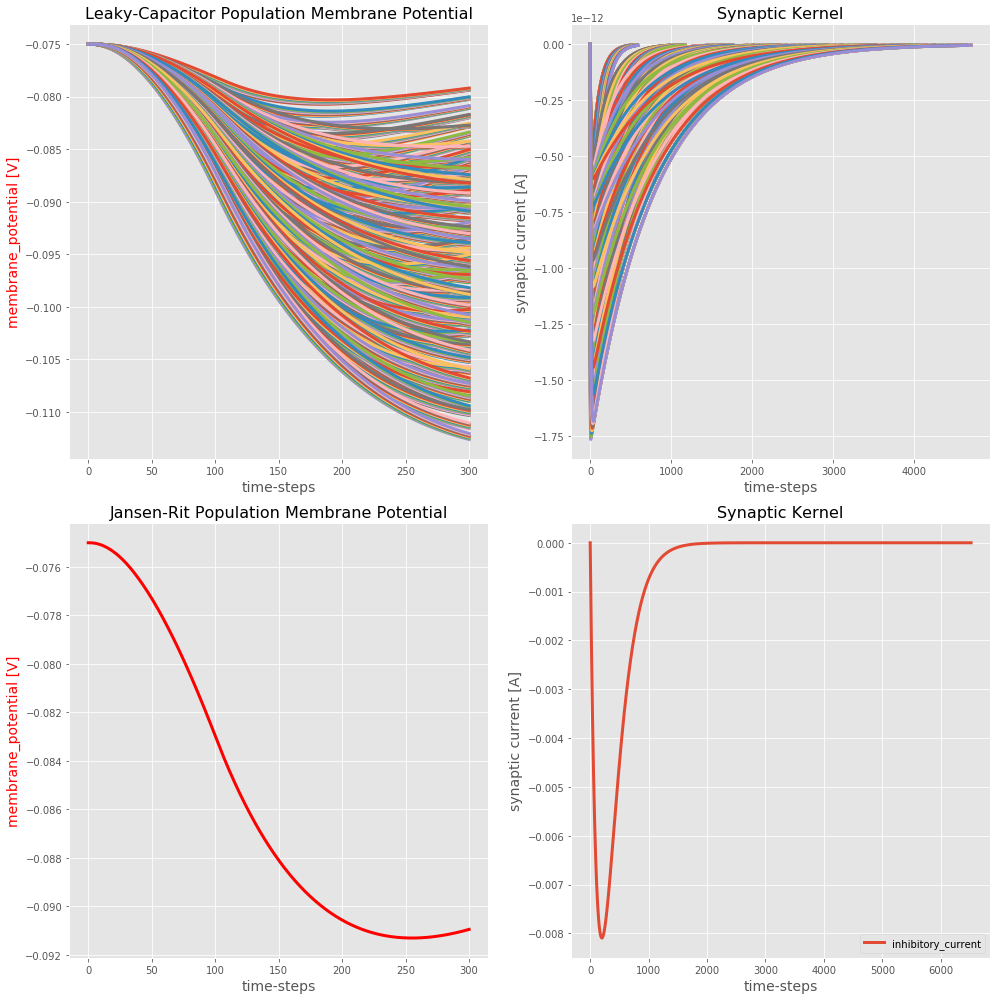

In [16]:
#########################################################
# plot synaptic kernels and population states over time #
#########################################################

fig, axes = plt.subplots(2,2, figsize=(14,14))

# first order states
ax1 = axes[0, 0]
for n in range(n_conditions):
    ax1.plot(double_exp_states[:, n].squeeze())
ax1.set_title('Leaky-Capacitor Population Membrane Potential')
ax1.set_xlabel('time-steps')
ax1.set_ylabel('membrane_potential [V]', color='r')

# first order kernels
ax2 = axes[0, 1]
for n in range(n_conditions):
    ax2 = synapses[n].plot_synaptic_kernel(create_plot=False, axes=ax2)

# second order states
ax3 = axes[1, 0]
ax3.plot(alpha_kernel_states, 'r')
ax3.set_title('Jansen-Rit Population Membrane Potential')
ax3.set_xlabel('time-steps')
ax3.set_ylabel('membrane_potential [V]', color='r')

# first order kernel
ax4 = axes[1, 1]
ax4 = alpha_kernel_population.plot_synaptic_kernels(create_plot=False, axes=ax4)

plt.tight_layout()

**4. Calculate Error between population states for each condition and find best parametrization**

Optimal synapse parameters:  {'tau_decay': 0.02, 'tau_rise': 0.00060000000000000006, 'epsilon': 5e-15, 'efficacy': -1.2729999999999997e-12}
Min NMRSE:  0.22946711287


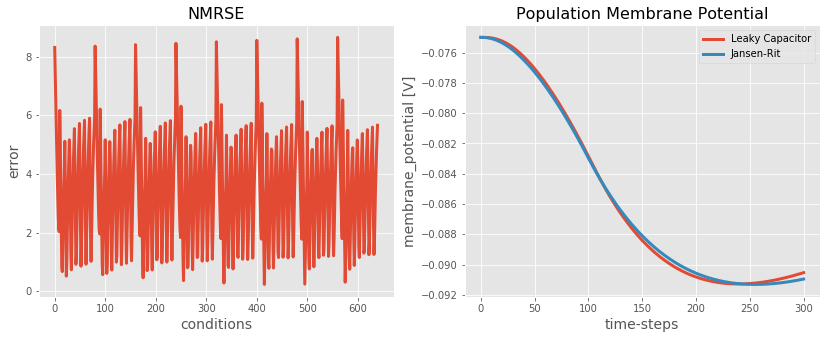

In [17]:
###############################################
# calculate the error between the time-series #
###############################################

errors = np.zeros(n_conditions)
for n in range(n_conditions):
    errors[n] = nmrse(double_exp_states[:, n].squeeze(), alpha_kernel_states.squeeze())

##############
# plot error #
##############

fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax1 = axes[0]
ax1.plot(errors)
ax1.set_ylabel('error')
ax1.set_xlabel('conditions')
ax1.set_title('NMRSE')

###########################################
# show parameters of best fitting synapse #
###########################################

idx = np.argmin(errors)
synapse_params = synapse_params1[idx]
print('Optimal synapse parameters: ', synapse_params)
print('Min NMRSE: ', errors[idx])

#####################################################
# plot best fitting states with second order states #
#####################################################

ax2 = axes[1]
ax2.plot(double_exp_states[:, idx].squeeze())
ax2.plot(alpha_kernel_states)
ax2.set_title('Population Membrane Potential')
ax2.set_xlabel('time-steps')
ax2.set_ylabel('membrane_potential [V]')
ax2.legend(['Leaky Capacitor', 'Jansen-Rit'])